## Predicting readmission of diabetic patients



**Table of contents**:
1. **Prepare Environment**:
2. **Exploratory Data Analysis**:
3. **Data preprocessing**:
4. **Model Fitting**:
5. **Model Evaluation**:
6. **Discussion**:
7. **References**:


**Caveat**: Modeling of health can be

The problem is important for the following reasons. Despite high-quality evidence showing improved clinical outcomes for patients with diabetes who receive various preventive and therapeutic interventions, many patients with diabetes do not receive them. This can be partially attributed to arbitrary diabetes management in hospital environments, which fail to attend to glycemic control. Failure to provide proper diabetes care not only increases the managing costs for the hospitals, as the patients are readmitted but also impacts the morbidity and mortality of the patients, who may face complications associated with diabetes.

Lets begin!

## Prepare Environment

In this section, we will (1) import the necessary Python packages to run this notebook, and (2) define some utilities to help downloading the data in an automatic fashion.

### Import dependencies

Instead of reinventing the wheel, we will leverage already existing Python packages. We will use `numpy` and `pandas` to easily deal and preprocess the data,  `matplotlib` and `seaborn` to create visualizations during our data analysis and result discussion, and finally, `sklearn` to implement a simple Machine Learning (ML) pipeline, i.e., we will fit a model and evaluate its quality.



In [ ]:
# -----------------------------------------------------------
# Import data structures
# -----------------------------------------------------------
import numpy as np
import pandas as pd
pd.set_option("display.float_format", "{:.4f}".format)

# Import ML-related library
import sklearn as sk

# -----------------------------------------------------------
# Import visualization libraries
# -----------------------------------------------------------
# these will prove useful when analyzing the data but also
# when visualizing results
import matplotlib.pyplot as plt
import seaborn as sns
# add default configurations for the plots
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="whitegrid", palette="colorblind", rc=custom_params)

# Utils
from typing import Dict, List, Tuple

### Define auxiliar methods

We'd like to download the [Diabetes 130-US hospitals for years 1999-2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) from the UCI Repository in order to run this notebook.

Let us define an auxiliary function to help us with downloading the data, we'll call it `download_diabetes_readmission_data`. This method expects no argument and it will return the tabular representation of the diabetes dataset available in the UCI repository. We represent this tabular data using a structure called `pandas.DataFrame`.




In [ ]:
def load_diabetes_readmission_data() -> Tuple[pd.DataFrame, pd.DataFrame]:
  """Downloads the diabetes readmission data from the UCI repository."""
  import os, requests, zipfile
  # -----------------------------------------------------------
  # Obtain the data zip file and uncompress it
  # -----------------------------------------------------------
  url = "https://archive.ics.uci.edu/static/public/296/diabetes+130-us+hospitals+for+years+1999-2008.zip"
  print(f"Downloading dataset from {url}...")
  r = requests.get(url, allow_redirects=True)

  filepath = "../content/diabetes_readmission.zip"
  print(f"Persisting zip file {filepath}...")
  with open(filepath, "wb") as f:
    f.write(r.content)

  with zipfile.ZipFile(filepath, "r") as zip_ref:
    zip_ref.extractall(f"../content")

  return pd.read_csv("diabetic_data.csv")

#### Plotting utils

In [ ]:
def plot_pie(data: pd.DataFrame, col: str, colors=None, figsize=(4, 3), missing="?"):
    key_vals = sorted(data[col].value_counts().items(), key=lambda x: x[0] if x[0].lower() != missing else "zzzzz")
    keys, d = zip(*key_vals)
    fig, ax = plt.subplots(figsize=(6, 3), subplot_kw=dict(aspect="equal"), dpi=150)
    if colors is None:
        palette_color = sns.color_palette("colorblind")
    else:
        palette_color = sns.color_palette(colors)

    # plotting data on chart
    wedges, texts, autotexts =  plt.pie(d, labels=keys, colors=palette_color, autopct='%.1f%%')
#    wedges, texts, autotexts =  plt.pie(d, colors=palette_color, autopct='%.1f%%')

    for autotext in autotexts:
        autotext.set_color("white")

    plt.setp(autotexts, size=7, weight="bold")
 #   ax.legend(wedges, keys,
  #        title="Patient's Age (binns)",
  #        loc="center left",
  #        bbox_to_anchor=(1, 0, 0.5, 1))



In [ ]:
def plot_counts_barplot(data: pd.DataFrame, col: str, figsize=(8, 5), palette=None):
  col_counts = sorted(data[col].value_counts().items(), key=lambda x: x[0])
  vals, counts = zip(*col_counts)

  if palette is not None:
    palette = sns.color_palette(palette, n_colors=len(col_counts))

  plt.figure(figsize=figsize)
  plots = sns.barplot(x=np.array(vals), y=np.array(counts), palette=palette)

  for bar in plots.patches:
    # Using Matplotlib's annotate function and
    # passing the coordinates where the annotation shall be done
    # x-coordinate: bar.get_x() + bar.get_width() / 2
    # y-coordinate: bar.get_height()
    # free space to be left to make graph pleasing: (0, 8)
    # ha and va stand for the horizontal and vertical alignment
    plots.annotate(
      format(bar.get_height() / len(data), '.2%'),
      (bar.get_x() + bar.get_width() / 2, bar.get_height()),
      ha='center', va='center', size=10, xytext=(0, 8),
      textcoords='offset points',
    )
  plt.tight_layout()

## Exploratory Data Analysis (EDA)


Often overlooked, **Exploratory Data Analysis (EDA)** is one of the most important stages of the machine learning pipeline.
Using information gathered during this data analysis stage, we can inform decisions about not only which covariates and transformations to apply to the data but also about which machine learning algorithms to use.


In this section, we will (1) download the data, (2) obtain fundamental statistics about the data, (3) observe the covariates' distributions, and, finally, (4) assess whether there are any correlations we should take into account.

By the end of this section, you should be able to answer the following questions:

- How many records and covariates does the data have?
- How is the data organized? Is it represented in terms of unique patient identifiers or are there multiple records for the same patient?
- Does the distribution of the covariates make intuitive sense?
- Are there any correlations worth accounting for? Do they make intuitive sense?
- What is the distribution of the label? What is the distribution of the label across different socio-demographic groups?
- Is the data sample representative of the general population?

### Load data

In [ ]:
data = load_diabetes_readmission_data()

Persisting zip file ../content/diabetes_readmission.zip...


### Data basics

Let us first analyze how many rows and columns, we have access to.

In [ ]:
data.head(5)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
num_rows, num_cols = data.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

print()
print("Number of unique patients:", data["patient_nbr"].nunique())

Number of rows: 101766
Number of columns: 50

Number of unique patients: 71518


There are about 102k rows and 50 columns. Note, however, that from these 102k records, we have a **total of 71.5k unique patients**!


In fact, we're going to observe how many records do we have per patient. To this end, we will first compute for each patient, how many times it visited the hospital. Then, we will observe how many times do the patients visits the hospital.

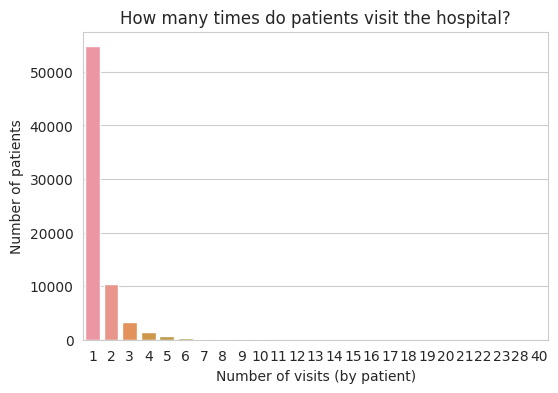

In [ ]:
# Obtain the number of total visits by patient
dist_visits_per_patient = data.groupby("patient_nbr").count()["encounter_id"]
# Compute proportion of times each patient visits the hospital X times
dist_visits_per_patient = dist_visits_per_patient.value_counts()
num_visits, counts = zip(*dist_visits_per_patient.items())
num_visits, counts = np.array(num_visits), np.array(counts)

plt.figure(figsize=(6, 4), dpi=100)
sns.barplot(x=num_visits, y=counts)
plt.xlabel("Number of visits (by patient)")
plt.ylabel("Number of patients")
plt.title("How many times do patients visit the hospital?")
plt.show()

To obtain a birds-eye view of the metadata of the diabetic patients readmission dataset, we can use the method `data.info()`. This will provide us information regarding the name of the columns, their type (e.g., numerical, ordinal, or categorical), and also about the missing values for each column.

**Column Names**: To better leverage this information, you may have to cross-reference the name of the columns with the metadata available in the [UCI Repository](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008) data.

**Column types**: In general, the numerical features will be listed as `float64`, the ordinal features as `int64`, and the categorical features as `objects`.

**Missing values**: Sometimes, it is the case that some columns have missing values. This could be caused by failures of the system and/or for example due to domain constraints, like only conducting specific exams or analysis in case of suspicious diseases.

---

As you proceed with the data analysis, you should ponder whether it makes sense for these columns to be included in the predictive model, if they are irrelevant to the problem (e.g., too noisy, high percentage of missing values), or if they are leaking information about the predictive task.




In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

We can observe a few things:

1. At a first glance, there seems to be no missing data (all columns exhibit a `Non-Null Count` of `101766`, which is the same name of the total rows of our data). This does not match with metadata in UCI repo, so there's a chance that the missing data was encoded somehow.
2. We have categorical, numerical, and ordinal covariates.



### Demographics

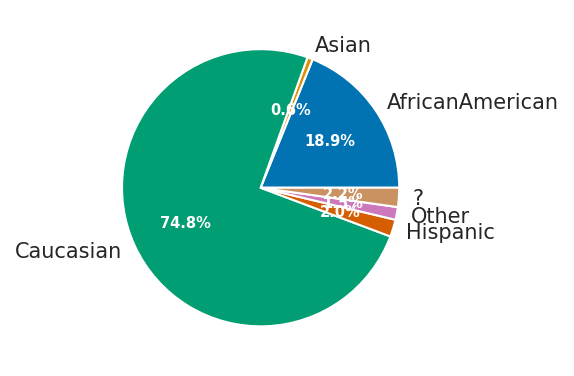

In [ ]:
plot_pie(data, "race")
# plot_pie(data.groupby("patient_nbr").head(1), "race")

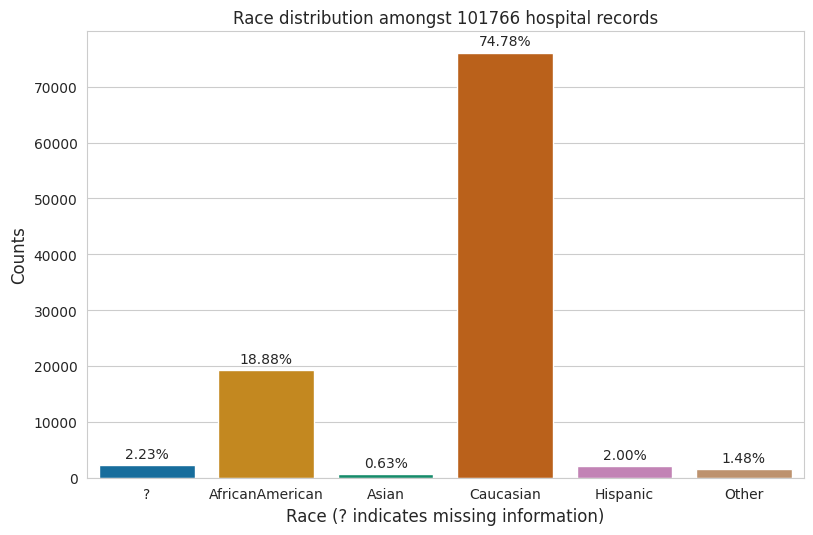

In [ ]:
plot_counts_barplot(data, "race")
# Setting the label for x-axis
plt.xlabel("Race (? indicates missing information)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Race distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

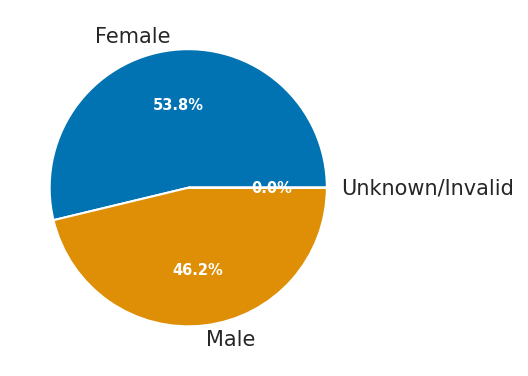

In [ ]:
plot_pie(data, "gender")

In [ ]:
data["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

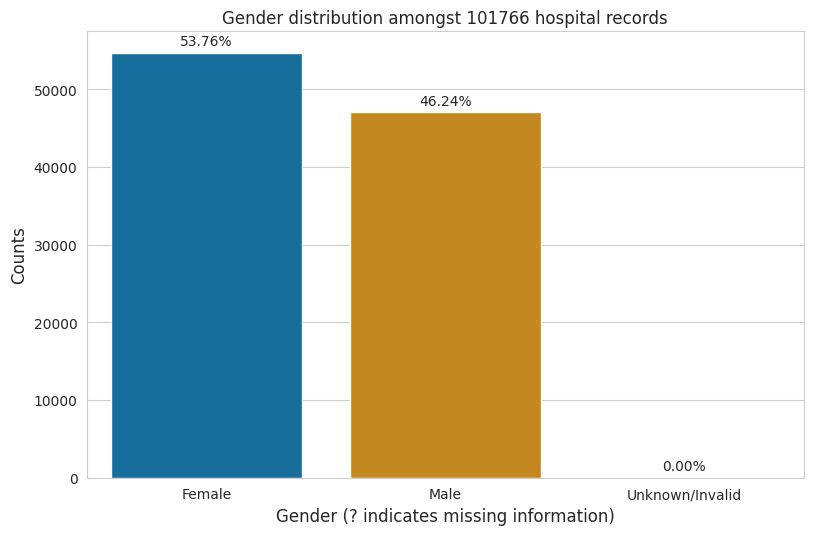

In [ ]:
plot_counts_barplot(data, "gender")
# Setting the label for x-axis
plt.xlabel("Gender (? indicates missing information)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Gender distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64

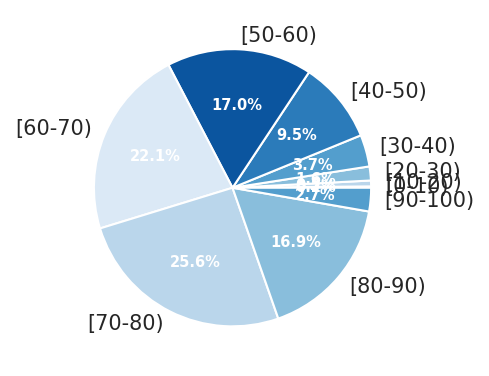

In [ ]:
plot_pie(data, "age", "Blues")
data.sort_values("age")["age"].value_counts() / len(data)

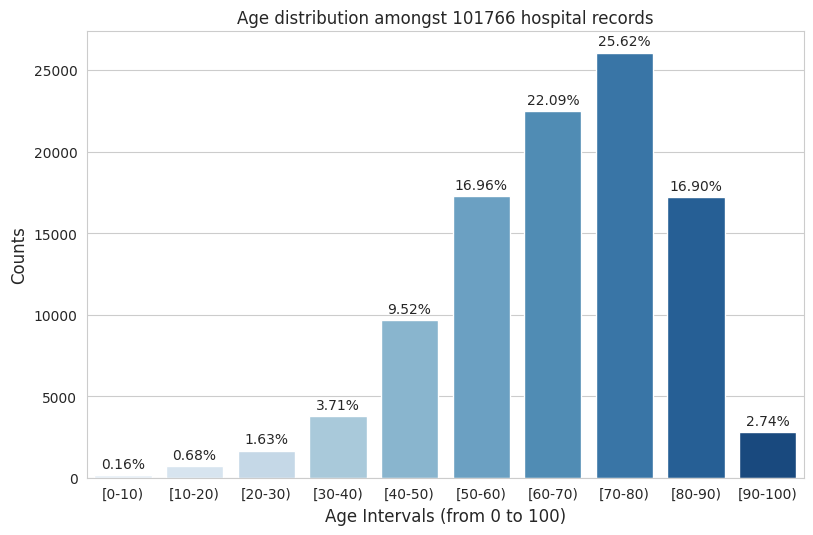

In [ ]:
plot_counts_barplot(data, "age", palette="Blues")
# Setting the label for x-axis
plt.xlabel("Age Intervals (from 0 to 100)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Age distribution amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

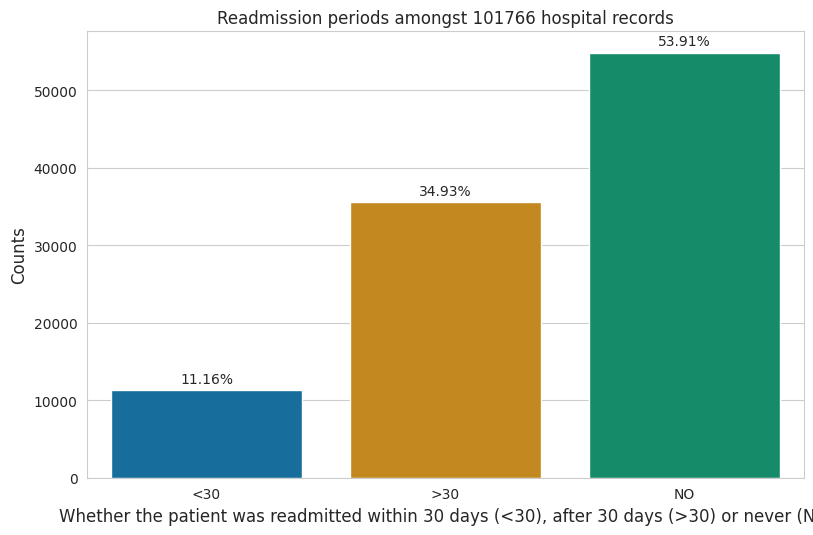

In [ ]:
plot_counts_barplot(data, "readmitted")

# Setting the label for x-axis
plt.xlabel("Whether the patient was readmitted within 30 days (<30), after 30 days (>30) or never (No)", size=12)
# Setting the label for y-axis
plt.ylabel("Counts", size=12)
# Setting the title for the graph
plt.title(f"Readmission periods amongst {len(data)} hospital records")
# Finally showing the plot
plt.show()

In [ ]:
1

In [ ]:
data_unique_patients["race"].

0               Caucasian
1               Caucasian
2         AfricanAmerican
3               Caucasian
4               Caucasian
               ...       
101754          Caucasian
101755              Other
101756              Other
101758          Caucasian
101765          Caucasian
Name: race, Length: 71518, dtype: object

## Data Preprocessing

create a relatively simple Python script (or jupyter notebook)  that can
1. download the data (its ok if you download a “local” version rather than from the original source),
2. does some very simple summarization of data properties (e.g., number of variables, number of patients, distribution of y-variable),
3. generates a simple histogram/density plot for 1 or 2 single variables and then a scatter plot of some 2 variables of interest (the seaborn library is quite nice),
4. and then fits a simple ML model (e.g., using scikit-learn) and evaluates it (accuracy, AUC, etc) on a test set.

This should be very simple and clearly explained - in the manner you would do if you **were teaching someone concepts in machine learning** for the first time. It would probably be a good idea to share these scripts with each other; they don’t need to be super-similar, but it would probably be good if they share similar plotting styles, etc.

In [ ]:
#download data
import pandas as pd
df = pd.read_csv("diabetic_data.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (101766, 50)


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
#simple summary
print("Number of rows (admissions):", df.shape[0])
print("Number of variables (features):", df.shape[1])

df_raw = pd.read_csv("diabetic_data.csv")
print("Number of unique patients:", df_raw['patient_nbr'].nunique())
df['readmitted_binary'] = df_raw['readmitted'].apply(lambda x:1 if x =='<30' else 0)
print("\nDistribution of 'readmitted_binary':")
print(df['readmitted_binary'].value_counts())

Number of rows (admissions): 101766
Number of variables (features): 50
Number of unique patients: 71518

Distribution of 'readmitted_binary':
readmitted_binary
0    90409
1    11357
Name: count, dtype: int64


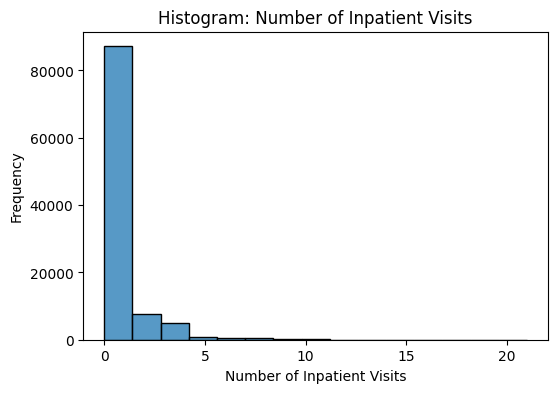

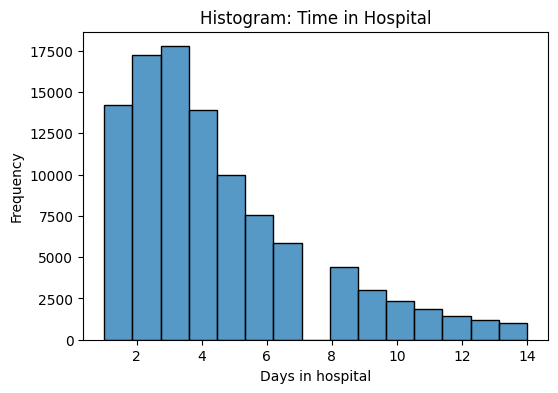

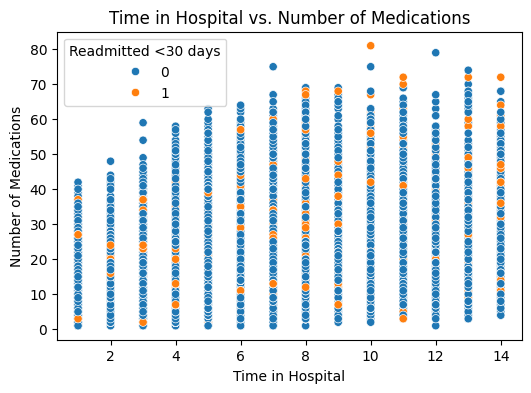

In [ ]:
# plots
import seaborn as sns
import matplotlib.pyplot as plt

#Histogram: Number of Inpatient Visits
plt.figure(figsize=(6, 4))
sns.histplot(df['number_inpatient'], bins=15)
plt.title("Histogram: Number of Inpatient Visits")
plt.xlabel("Number of Inpatient Visits")
plt.ylabel("Frequency")
plt.show()

#Histogram: Time in Hospital
plt.figure(figsize=(6, 4))
sns.histplot(df['time_in_hospital'], bins=15)
plt.title("Histogram: Time in Hospital")
plt.xlabel("Days in hospital")
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Time in Hospital vs. Number of Medications
plt.figure(figsize=(6,4))
sns.scatterplot(x='time_in_hospital', y='num_medications', hue='readmitted_binary', data=df)
plt.title("Time in Hospital vs. Number of Medications")
plt.xlabel("Time in Hospital")
plt.ylabel("Number of Medications")
plt.legend(title='Readmitted <30 days')
plt.show()

In [ ]:
#cleaning the columns
cols_to_drop = ['encounter_id', 'patient_nbr', 'weight', 'payer_code', 'medical_specialty']
df = df.drop(columns=cols_to_drop)
df.replace('?', pd.NA, inplace=True)
df.dropna(inplace=True)

In [ ]:
#create target
df['readmitted_binary'] = df['readmitted'].apply(lambda x: 1 if x == '<30' else 0)
df = df.drop(columns=['readmitted'])

In [ ]:
#encoding features
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [ ]:
#X are features; y is target
from sklearn.model_selection import train_test_split
X = df.drop(columns=['readmitted_binary'])
y = df['readmitted_binary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
#standardize the data to make sure features are on the same scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Model Fitting

In [ ]:
#Logistic Regression
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

## Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

#Logistic Regression
log_preds = log_model.predict(X_test_scaled)
log_auc = roc_auc_score(y_test, log_model.predict_proba(X_test_scaled)[:, 1])
print("Logistic Regression AUC Score:", round(log_auc, 4))
print("Classification Report:\n")
print(classification_report(y_test, log_preds, zero_division=0))

Logistic Regression AUC Score: 0.7311
Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.96      0.92        51
           1       0.00      0.00      0.00         7

    accuracy                           0.84        58
   macro avg       0.44      0.48      0.46        58
weighted avg       0.77      0.84      0.81        58



In [42]:
#Random Forest
rf_preds = rf_model.predict(X_test_scaled)
rf_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test_scaled)[:, 1])
print("Random Forest AUC Score:", round(rf_auc, 4))
print("Classification Report:\n")
print(classification_report(y_test, rf_preds, zero_division=0))

Random Forest AUC Score: 0.7017
Classification Report:

              precision    recall  f1-score   support

           0       0.88      1.00      0.94        51
           1       0.00      0.00      0.00         7

    accuracy                           0.88        58
   macro avg       0.44      0.50      0.47        58
weighted avg       0.77      0.88      0.82        58



## Discussion

**Homework 1 Report:**
*Results and Findings*
- I used the Diabetes 130-US Hospitals for Years 1999-2008 dataset from the UCI Machine Learning Repository. This was a multivariate dataset with 101766 instances and 47 features.
- I attempted to compare two different models to predict whether a patient with diabetes would be readmitted to the hospital within 30 days of discharge.
- I did a binary classification by classifying the target variable of readmitted as 1 if readmitted within 30 days or 0 if not readmitted in that timeframe.
- I got rid of any columns with irrelevant data and any data that had a lot of missing values

My Models
- For my two models, I used logistic regression and random forest and evaluated them using ROC AUC and classification reports of precision, recall, f1-score, and support.
- I split the data into training and testing data with 80% being training and 20% of it being testing data.

My Results

| Metric             | Logistic Regression | Random Forest |
|-------------------|---------------------|----------------|
| AUC               | 0.7311              | 0.7017         |
| F1 Score (`<30`)  | 0.00                | 0.00           |
| Recall (`<30`)    | 0.00                | 0.00           |

My Findings
- The data seemed to be imbalanced. There were only 7 out of the 58 samples that were readmitted within 30 days.
- Because of this, the models were unable to properly predict this even though the AUC scores of 0.7311 and 0.7017 showed the models performed well.

## References

1. UCI ML Repo
2. Original dataset
3. Fairlearn tutorial

References

In [43]:
#Data Set: Clore, J., Cios, K., DeShazo, J., & Strack, B. (2014). Diabetes 130-US Hospitals for Years 1999-2008 [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5230J.